In [1]:
import os
import datetime
import pickle
import subprocess

import pathlib as pl
import networkx as nx
import pandas as pd
import numpy as np

from scipy import stats

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['font.family'] = "serif"
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)

## Define paths.

In [3]:
# Inputs.
data_dir = pl.Path('../data')
graph_file = data_dir.joinpath('metadata/network.json')

logs_dir = data_dir.joinpath('logs')

# Outputs.
output_dir = pl.Path('../outputs')
temp_dir = output_dir.joinpath('temp')
intermediate_dir = output_dir.joinpath('intermediate')

for folder in [intermediate_dir]:
    if not folder.exists():
        folder.mkdir(parents=True)

## Load data.

### Load logs.

#### Make a list of the available log files.

In [4]:
log_filelist = sorted([f for f in logs_dir.glob('*.csv')])
print('{} log files found.'.format(len(log_filelist)))

39 log files found.


#### Organize the log file list as a dictionary keyed by team number.

In [5]:
def get_team_no_from_log_filename(filename):
    '''extract the team no from a log file name of format *_<team_no>.*'''
    return int(str(pl.Path(filename).stem).split('_')[-1])


log_files = {
    get_team_no_from_log_filename(f): f
    for f in log_filelist
}

for team_no, file in log_files.items():
    print('File {} belongs to task {:2d}'.format(file.stem, team_no))

File justhink19_log_06 belongs to task  6
File justhink19_log_07 belongs to task  7
File justhink19_log_08 belongs to task  8
File justhink19_log_09 belongs to task  9
File justhink19_log_10 belongs to task 10
File justhink19_log_11 belongs to task 11
File justhink19_log_12 belongs to task 12
File justhink19_log_14 belongs to task 14
File justhink19_log_15 belongs to task 15
File justhink19_log_16 belongs to task 16
File justhink19_log_17 belongs to task 17
File justhink19_log_18 belongs to task 18
File justhink19_log_19 belongs to task 19
File justhink19_log_20 belongs to task 20
File justhink19_log_21 belongs to task 21
File justhink19_log_22 belongs to task 22
File justhink19_log_23 belongs to task 23
File justhink19_log_25 belongs to task 25
File justhink19_log_26 belongs to task 26
File justhink19_log_27 belongs to task 27
File justhink19_log_28 belongs to task 28
File justhink19_log_29 belongs to task 29
File justhink19_log_30 belongs to task 30
File justhink19_log_31 belongs to 

#### Read the log files.

In [6]:
log_dfs = dict()

for team_no, f in log_files.items():
    # Read the file into a table.
    df = pd.read_csv(f, sep='\t')

    log_dfs[team_no] = df


for team_no, df in log_dfs.items():
    print('Table of {:2d} has {:4d} events'.format(team_no, len(df)))

Table of  6 has  100 events
Table of  7 has  420 events
Table of  8 has  263 events
Table of  9 has  266 events
Table of 10 has  300 events
Table of 11 has  343 events
Table of 12 has  386 events
Table of 14 has  166 events
Table of 15 has  322 events
Table of 16 has  171 events
Table of 17 has  126 events
Table of 18 has  147 events
Table of 19 has  252 events
Table of 20 has  146 events
Table of 21 has  188 events
Table of 22 has  247 events
Table of 23 has  394 events
Table of 25 has  142 events
Table of 26 has  205 events
Table of 27 has  221 events
Table of 28 has  142 events
Table of 29 has  226 events
Table of 30 has  307 events
Table of 31 has  201 events
Table of 32 has  221 events
Table of 33 has  156 events
Table of 34 has  196 events
Table of 35 has  286 events
Table of 36 has  210 events
Table of 37 has  180 events
Table of 38 has  289 events
Table of 39 has  182 events
Table of 40 has  233 events
Table of 41 has  113 events
Table of 42 has  140 events
Table of 44 has  357

#### Combine the log tables into a corpus.

In [7]:
data_df = pd.concat(log_dfs.values(), ignore_index=True)
data_df.insert(2, 'corpus_no', 1)

### Load the background graph.


#### Load from file, formatted as a node-link JSON.

c.f. https://networkx.org/documentation/stable/reference/readwrite/json_graph.html

in particular https://networkx.org/documentation/stable/reference/readwrite/generated/networkx.readwrite.json_graph.node_link_graph.html#networkx.readwrite.json_graph.node_link_graph

In [8]:
from networkx.readwrite import json_graph

def load_graph(graph_file):
    try:
        #graph = nx.read_graphml(str(graph_file), node_type=int)
        with pl.Path(graph_file).open() as f:
            data = json.load(f)
        graph = json_graph.node_link_graph(data)

        for u, v, d in graph.edges(data=True):
            u_node = graph.nodes[u]
            v_node = graph.nodes[v]
        
        return graph
    except IOError as e:
        # The file was missing.
        load_text = "File {} not found".format(graph_file)
        return nx.Graph()

    
graph = load_graph(graph_file)
print('Graph read from {}: {} nodes, {} edges'.format(
    graph_file, graph.number_of_nodes(), graph.number_of_edges()))

Graph read from ../data/metadata/network.json: 10 nodes, 20 edges


#### Visualize the graph.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71ec194a30>)

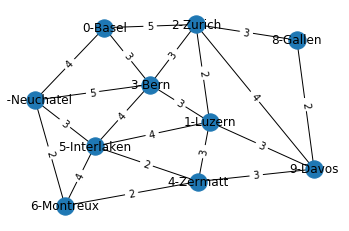

In [9]:
def draw_network(G, labels=None):

    x_values = nx.get_node_attributes(G, 'x')
    y_values = nx.get_node_attributes(G, 'y')

    pos = {u: (x_values[u], y_values[u]) for u in G.nodes()}

    fig, ax = plt.subplots()

    if labels is None:
        labels = {u: '{}-{}'.format(u, d['label'].split()[-1])
                  for u, d in G.nodes(data=True)}

    nx.draw(G,
            pos=pos,
            with_labels=True,
            labels=labels,
            nodelist=[u for u in G.nodes()],
            ax=ax)

    labels = nx.get_edge_attributes(G, 'cost')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    ax.margins(0.1)

    return fig, ax


draw_network(graph)

### Find the optimal solutions.
i.e. minimum spanning trees.

#### Find a minimum spanning tree.

MST found, 10 nodes, 9 edges, cost = 22


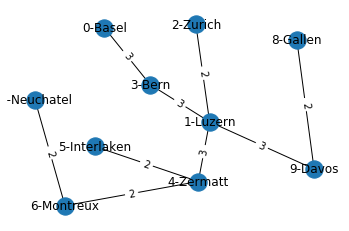

In [10]:
def solve_mst(G, weight_key='cost'):
    return nx.minimum_spanning_tree(G, weight=weight_key)


def calculate_graph_cost(G):
    return sum([d['cost'] for u, v, d in G.edges(data=True) if 'cost' in d])


def calculate_state_cost(state, graph):
    return calculate_edge_set_cost(state['G']['add'], graph)


def calculate_edge_set_cost(edge_set, graph):
    return sum([graph[u][v]['cost'] for u, v in edge_set])


mst_graph_1 = solve_mst(graph)
mst_graph_1.graph['cost'] = calculate_graph_cost(mst_graph_1)

print('MST found, {} nodes, {} edges, cost = {}'.format(
    mst_graph_1.number_of_nodes(), mst_graph_1.number_of_edges(),
    mst_graph_1.graph['cost']))

draw_network(mst_graph_1)
optimal_cost = mst_graph_1.graph['cost']

#### Construct the second one manually.

Alternative MST constructed, 10 nodes, 9 edges, cost = 22


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7160ec7eb0>)

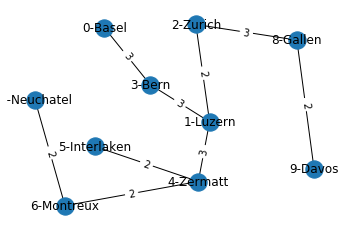

In [11]:
mst_graph_2 = mst_graph_1.copy()
mst_graph_2.add_edge(2, 8, cost=3)
mst_graph_2.remove_edge(1, 9)

mst_graph_2.graph['cost'] = calculate_graph_cost(mst_graph_2)
print('Alternative MST constructed, {} nodes, {} edges, cost = {}'.format(
    mst_graph_2.number_of_nodes(), mst_graph_2.number_of_edges(),
    mst_graph_2.graph['cost']))

draw_network(mst_graph_2)

### Extract features from logs.

Make a tables object to hold the data and computed feature tables.

In [12]:
tables = {'data': data_df}

Compute time difference between the time of consecutive event pairs.
To be used for computing duration later.

In [14]:
durations = lambda x: x['time'].diff().fillna(0)
data_df['duration'] = data_df.groupby('team_no').apply(durations).reset_index(drop=True)

### Create groups that represent the different granularities (levels of analysis).

Define four time granularities to study an actions corpus:
1. Corpus Level:  The whole collection of temporal team action data for all teams
1. Task level: The complete time that a team plays
2. Attempt level: The duration of the team constructing a solution and submitting it together
3. Turn level: The duration where one of the player is in figurative view 
4. Action level: actions done by the players or the tutor

In [ ]:
levels = {
    'corpus': data_df.groupby('corpus_no'),
    'task': data_df.groupby(['corpus_no', 'team_no']), 
    'attempt': data_df.groupby(['corpus_no', 'team_no', 'attempt_no']), 
    'turn': data_df.groupby(['team_no', 'attempt_no', 'turn_no']),
}

### Define the features as functions.

In [ ]:
# Performance Features

def success(x, opt_cost=optimal_cost):
    '''whether a team has succeeded i.e. found the optimal solution, at task level only'''
   # return x.name[-1] in metadata['success']
    c = cost(x)
    return not np.isnan(c) and c == opt_cost


def cost(x):
    '''the sum of the edge costs of the submitted solution'''
    submits = x[x['verb'].isin(['submits'])]
    if len(submits) > 0:
        return int(submits['object'].iloc[-1].split()[0].split('=')[-1])
    else:
        return np.nan


def abs_error(x, opt_cost=optimal_cost):
    '''absolute error, i.e. the difference between the cost of the submitted solution and the cost of an optimal/correct solution (optimal cost)'''
    return (cost(x) - opt_cost)


def error(x, opt_cost=optimal_cost):
    '''relative error, i.e. absolute error divided by the optimal cost'''
    return 1.0 * (cost(x) - opt_cost) / opt_cost

# Task/Attempt/Turn/Event Counts


def num_task(x):
    '''number of tasks, where a task is 
    the complete period that a team plays to find an optimal solution'''
    return len(x['team_no'].unique())


def num_attempt(x):
    '''number of attempts, where an attempt is the duration of the team constructing a solution and submitting it together as a proposal'''
    return len(x['attempt_no'].unique())


def num_turn(x):
    '''number of turns, where a turn is the duration where one player is in figurative view and the other player is in abstract view'''
    return len(x['turn_no'].unique())


def num_action(x):
    '''number of actions, where an action is something done by the players or the tutor.'''
    return len(x['subject'].isin(['A', 'B', 'R']))


def avg_turn(x):
    '''number of turns normalized by the number of attempts'''
    return 1.0 * num_turn(x) / num_attempt(x)


def avg_action_per_turn(x):
    '''number of actions normalized by the number of turns'''
    return 1.0 * num_action(x) / num_turn(x)


# Duration Related


def start(x):
    '''start time in seconds'''
    return x['time'].iloc[0]


def end(x):
    '''end time in seconds'''
    return x['time'].iloc[-1]


def duration(x):
    '''total time (in seconds) spent in the task until finding the optimal solution or time-up intervention'''
    return x['duration'].sum()


# Features on Edit Actions


def num_add(x):
    '''number of additions'''
    return x['verb'].isin(['adds']).sum()


def num_del(x):
    '''number of deletions'''
    return x['verb'].isin(['removes']).sum()


def num_edit(x):
    '''number of edits (additions and deletions) on the graph'''
    return num_add(x) + num_del(x)


def freq_add(x):
    '''relative frequency of additions, as divided by the total number of additions and deletions'''
    n = num_edit(x)
    if n == 0:
        return -1
    else:
        return 1.0 * num_add(x) / n


def freq_del(x):
    '''relative frequency of deletions, as normalized by the total number of additions and deletions'''
    return 1 - freq_add(x)

def num_histload(x):
    ''' how many times a previous solution was loaded i.e. brought back'''
    return x['object'].isin(['apply (enabled)']).sum()


def freq_histload(x):
    '''relative frequency of the previous solution was bring-backs 
    as normalized by the number of times the previous solutions were shown'''
    n = num_histview(x)
    if n == 0:
        return -1
    else:
        return 1.0 * num_histload(x) / n

# Evaluation Actions


def num_submitselect(x):
    '''number of times the current solution is selected for submission'''
    return x['object'].isin(['submit (disabled)']).sum()


def num_histview(x):
    '''number of times the player opens to view the solutions history'''
    return x['object'].isin(['compare (enabled)']).sum()


def num_histnext(x):
    '''number of times the player chooses to view the next solution in the solutions history'''
    return x['object'].isin(['next (enabled)']).sum()


def num_histprev(x):
    '''number of times the player chooses to view the previous solution in the solutions history'''
    return x['object'].isin(['previous (enabled)']).sum()


def num_histnavi(x):
    '''number of times the player chooses to navigate (view next or view previous)  
    among the solutions in the solutions history'''
    return num_histnext(x) + num_histprev(x)

# Other


def num_help(x):
    '''number of times a player opened help/info window'''
    return x['object'].isin(['help (enabled)']).sum()


def last_valid_value(x):
    '''the error of the last completed attempt'''
    return x.iloc[-1] if not np.isnan(x.iloc[-1]) else x.iloc[-2]


def series_range(x):
    #     x = x[1:]
    '''maximum - minimum of the sequence'''
    return np.max(x) - np.min(x)


def series_slope(x):
    #     x = x[1:]
    '''(simple linear) regression coefficient (i.e. slope) of the sequence'''
    x = x[~np.isnan(x)]
    if len(np.unique(x)) == 1:
        return 0.0
    y = np.arange(len(x))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return slope


def series_noninc(x):
    '''True if the sequence is non-increasing, False otherwise.'''
    for i in range(len(x) - 1):
        if x.iloc[i+1] > x.iloc[i]:
            return False
    return True


def compute_features(grouped, functions=[], df=None, inplace=False, insert_index=None):
    '''Computes features on a grouped object from a list of functions'''
    if df is not None and not inplace:
        df = df.copy()

    if insert_index is not None:
        functions.reverse()

    for i, entry in enumerate(functions):
        s = entry.__name__ if hasattr(entry, '__name__') else entry
        print('Computing feature {}'.format(s))

        if callable(entry):  # if it is a function
            func = entry
            result_column = func.__name__

            if df is None and i == 0:
                df = grouped.apply(func).to_frame(func.__name__)
            else:
                i = len(df.columns) if insert_index is None else insert_index
                df.insert(i, result_column, grouped.apply(func))

        elif type(entry) is list:
            applied_column, prefix_func_pairs = entry

            if insert_index is not None:
                prefix_func_pairs.reverse()

            for prefix, func in prefix_func_pairs:
                result_column = '{}_{}'.format(prefix, applied_column)

                i = len(df.columns) if insert_index is None else insert_index

                if df is None and i == 0:
                    df = grouped[applied_column].apply(
                        func).to_frame(result_column)
                else:
                    df.insert(i, result_column,
                              grouped[applied_column].apply(func))

    return df

### Compute attempt level features.

In [ ]:
# Compute task features.
attempt_features = [
    cost, abs_error, error,
    # Attempt/Turn/Event Counts
    num_turn, num_action,
    # Time Related
    duration, start, end,
#     # Edit Action Related
    num_add, num_del, num_edit, freq_add, freq_del, num_histload, freq_histload,
#     # Evaluation Action Related
#     num_submitselect, num_histview, num_histnext, num_histprev, num_histnavi,
#     # Other
#     num_help,
    success,
    ]
tables['attempt'] = compute_features(levels['attempt'], attempt_features)

# Display the task features table.
tables['attempt'] #.describe()

### Compute task level features.

In [ ]:
# Compute task features.
task_features = [
    success,
    # Attempt/Turn/Event Counts
    num_attempt, avg_turn, avg_action_per_turn, num_turn, num_action,
    # Time Related
    duration,
    # Edit Action Related
    # num_add, num_del, 
    num_edit, freq_add, 
    #freq_del, num_histload, 
    freq_histload,
    # Evaluation Action Related
    num_submitselect, 
    num_histview,
    # num_histnext, num_histprev, num_histnavi,
    # Other
    num_help,
    ]
tables['task'] = compute_features(levels['task'], task_features)

attempt_to_task_features = [
    ['error', [
        ('last', last_valid_value),
        ('max', np.max),
        ('min', np.min),
        ('range', series_range),
        ('avg', np.mean),
        ('std', np.std), 
        ('noninc', series_noninc),
        ('slope', series_slope),
        ]
    ], 
]
grouped = tables['attempt'].reset_index().groupby(['corpus_no', 'team_no'])
insert_index = 0
compute_features(grouped, attempt_to_task_features, df=tables['task'], 
                 insert_index=insert_index, inplace=True)

# Display the task features table.
tables['task']

### Compute turn level features.

In [ ]:
# Compute task features.
turn_features = [
    # Attempt/Turn/Event Counts
    num_action,
    # Time Related
    duration,
#     # Edit Action Related
    num_add, num_del, num_edit, freq_add, freq_del, # num_histload, freq_histload,
#     # Evaluation Action Related
#     num_submitselect, num_histview, num_histnext, num_histprev, num_histnavi,
#     # Other
#     num_help,
    ]
tables['turn'] = compute_features(levels['turn'], turn_features)

# Display the task features table.
# tables['turn'] #.describe()

### Compute corpus level features.

In [ ]:
corpus_features = [num_task] #num_success] #, freq_success]

grouped = tables['task'].reset_index().groupby('corpus_no')
tables['corpus'] = compute_features(grouped, corpus_features)

features = tables['task'].columns
# features = ['num_attempt', 'num_turn', 'num_action', 'num_add', 'num_del', 'success']

df = tables['task'][features].groupby('corpus_no').agg([np.sum, np.mean, np.std, np.max, np.min])
df.columns = ['_'.join(reversed(col)).strip() for col in df.columns.values]

tables['corpus'] = pd.concat([tables['corpus'], df], axis=1)

column_map = {
    'sum_success':'num_success', 
    'mean_success':'freq_success',
}
tables['corpus'].columns = [column_map[c] if c in column_map else c for c in tables['corpus'].columns]
tables['corpus'] = tables['corpus'].T
tables['corpus']

### Draw heatmaps.

In [ ]:
from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = pearsonr(df[r], df[c])[1]
    return pvalues


p_thres = 0.05

df = tables['task']
pvalues_df = calculate_pvalues(df)

In [ ]:
df = tables['task']
corr = df.corr(method='pearson')

corr = corr.round(2)
fig, ax = plt.subplots(figsize=(16, 8)) 
annot_kws = {} 

sns.set(font_scale=1.1)            
sns_plot_1 = sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='coolwarm', 
            robust=True,
            annot=True,
            fmt='.2f',
            annot_kws=annot_kws,
            linewidth=1, #1.5,

            ax=ax)

from matplotlib.patches import Rectangle

for i, annot in enumerate(ax.texts):
    row = i % len(pvalues_df)
    col = int(i / len(pvalues_df))
    p_val = pvalues_df.iloc[row, col]
    annot.set_text('{:.2f}'.format(np.abs(float(annot.get_text()))))
    if 1 - float(annot.get_text()) < 0.001:
        annot.set_visible(False)
    elif p_val < p_thres:
        annot.set_weight('bold')
        annot.set_text('{}'.format(annot.get_text()))

        ax.add_patch(Rectangle((row, col), 1, 1, fill=False, edgecolor='black', lw=2)) #blue

print('Significant (p < 0.05) values (without correction for multiple testing) are in bold and highlighted with a border"')

### Export a separate table for each level.

In [ ]:
tables.keys()

for key, data in tables.items():
    if key in ['data']:
        continue
        
    file = 'justhink19_log_features_{}_level.csv'.format(key)
    file = intermediate_dir.joinpath(file)
    
    data.to_csv(str(file))
    
    print(key, 'table is exported to', file)